In [8]:
from PIL import Image
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization, Flatten, Dense, Dropout)
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import warnings

In [10]:
# Function to plot loss, accuracy and best epoch
def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [11]:
def train_val_test_data(batch_size, img_size, train_directory, validation_directory, test_directory):

    train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=42)

    validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                     shuffle=False,
                                                                     batch_size=batch_size,
                                                                     image_size=img_size,
                                                                     seed=42)

    test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                               batch_size=batch_size,
                                                               image_size=img_size,
                                                               shuffle=False,
                                                               seed=42)

    class_names = train_dataset.class_names
    return train_dataset, validation_dataset, test_dataset, class_names

In [12]:
# Function to load image using URL and plot with predicted class
def load_prep(img_path, img_title):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image)
    image = tf.image.resize(image,size=(224,224))

    plt.imshow(image / 255.)
    plt.title(img_title)
    plt.suptitle(image.shape)

In [13]:
def show_samples(data_dir, class_names, num_samples=3):
    """
    Display a random sample of images from each class.
    
    Parameters:
    - data_dir: The base directory containing subfolders for each class.
    - class_names: List of class names (subfolders in the data_dir).
    - num_samples: Number of random samples to display from each class.
    """
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 3, len(class_names) * 3))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        
        # Randomly select images from the class folder
        selected_images = random.sample(images, num_samples)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')  # Hide axis
            
            # Set the title above each image
            axes[i, j].set_title(class_name, fontsize=10, pad=10)
    
    plt.tight_layout()
    plt.show()

In [14]:
def learning_curves_tuning(tr_data, start_epoch, history_fine=None, fine_tune_epoch=None):
    # Get training and validation data from initial training
    tacc = tr_data.history['accuracy'][:]
    tloss = tr_data.history['loss'][:]
    vacc = tr_data.history['val_accuracy'][:]
    vloss = tr_data.history['val_loss'][:]

    # Ensure the lengths of training data and epochs match
    train_epochs_count = len(tacc) + start_epoch  # or len(vloss), should be the same
    train_epochs = list(range(1, train_epochs_count + 1))

    # If fine-tuning data exists, concatenate it
    if history_fine:
        tacc += history_fine.history['accuracy']
        tloss += history_fine.history['loss']
        vacc += history_fine.history['val_accuracy']
        vloss += history_fine.history['val_loss']

    # Ensure the total epoch count matches the combined data
    total_epochs_count = len(tacc)  # Now the length should match tloss or vloss
    total_epochs = list(range(1, total_epochs_count + 1))

    # Find best epoch based on validation loss and accuracy
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # epoch with the highest validation accuracy
    acc_highest = vacc[index_acc]

    # Define plot labels
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot loss curves
    axes[0].plot(total_epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(total_epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    
    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[0].axvline(x=fine_tune_epoch, color='orange', linestyle='--', label='Start Fine Tuning')

    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot accuracy curves
    axes[1].plot(total_epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(total_epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    
    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[1].axvline(x=fine_tune_epoch, color='orange', linestyle='--', label='Start Fine Tuning')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [28]:
data_dir = "./Data"

In [29]:
class_names = [class_name for class_name in os.listdir(data_dir)]
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

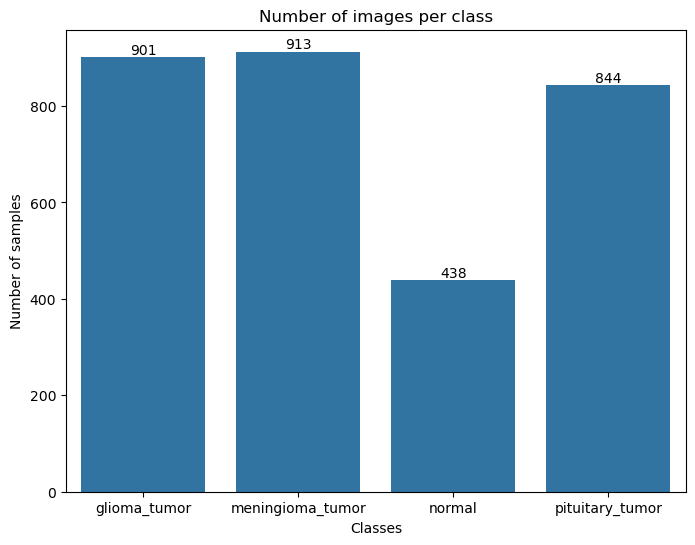

In [30]:
counts = [] 
# Loop over classes to iterate below code for each class
for class_name in class_names :
    # Define class path by joining base_directory and class_name
    class_path = os.path.join(data_dir, class_name)
    counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_names, y=counts)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

In [31]:
# Create new directories for train, validation, and test splits
output_dirs = {
    'train': '/kaggle/working/train',
    'val': '/kaggle/working/val',
    'test': '/kaggle/working/test'
}

# Make sure the directories exist
for split in output_dirs.values():
    os.makedirs(split, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(split, class_name), exist_ok=True)

# Loop through each class folder and collect image paths
image_paths = []
image_labels = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img_name))
        image_labels.append(class_name)

# Split data into train (80%), val+test (20%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.1, stratify=image_labels, random_state=42
)

# Further split val_test into validation (10%) and test (10%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.11, stratify=train_val_labels, random_state=42
)

# Function to move files to their corresponding directories
def move_files(file_paths, file_labels, split):
    for img_path, label in zip(file_paths, file_labels):
        dest_folder = os.path.join(output_dirs[split], label)
        shutil.copy(img_path, dest_folder)  # Use shutil.move if you want to move instead of copy

# Move images to train, validation, and test folders
move_files(train_paths, train_labels, 'train')
move_files(val_paths, val_labels, 'val')
move_files(test_paths, test_labels, 'test')

print("Dataset split completed!")

Dataset split completed!


In [32]:
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

batch_size=16
image_shape = (224, 224)

train, val, test, class_names = train_val_test_data(batch_size, image_shape, train_dir, val_dir, test_dir)

Found 2479 files belonging to 4 classes.
Found 307 files belonging to 4 classes.
Found 310 files belonging to 4 classes.


In [33]:
def count_images_in_directory(directory):
    """Count the number of images in each class within a given directory."""
    counts = {}
    # Loop over classes (subdirectories)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            counts[class_name] = len(os.listdir(class_path))  # Count files
    return counts

# Count images for each split
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)

# Print the counts
print("Training Set Counts:")
print(train_counts)
print("\nValidation Set Counts:")
print(val_counts)
print("\nTest Set Counts:")
print(test_counts)

Training Set Counts:
{'glioma_tumor': 722, 'meningioma_tumor': 731, 'normal': 351, 'pituitary_tumor': 675}

Validation Set Counts:
{'glioma_tumor': 89, 'meningioma_tumor': 91, 'normal': 43, 'pituitary_tumor': 84}

Test Set Counts:
{'glioma_tumor': 90, 'meningioma_tumor': 91, 'normal': 44, 'pituitary_tumor': 85}


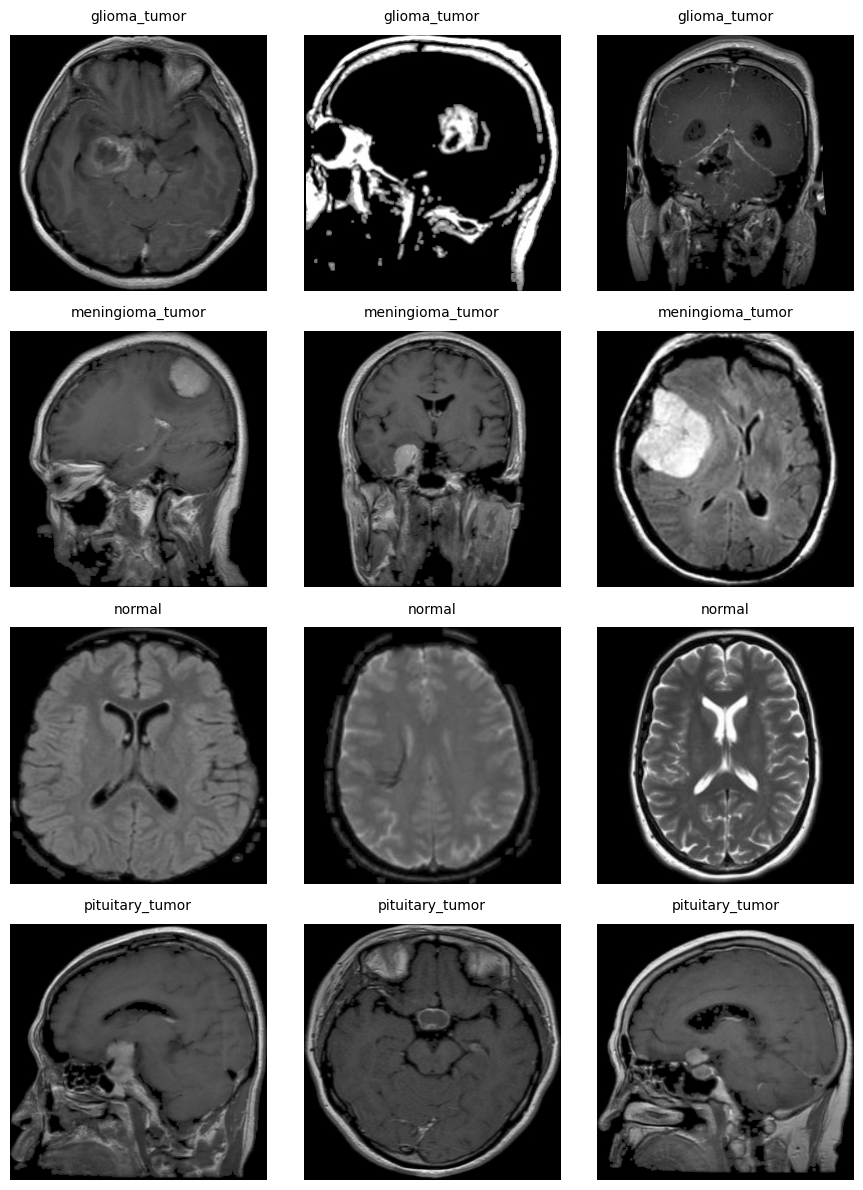

In [34]:
# Show 3 random samples from each class
show_samples(train_dir, class_names, num_samples=3)